## 모델링 준비

### 테이블 불러오기

In [1]:
# 라이브러리
from google.cloud import storage
import io
import pandas as pd
import gcsfs
import os

In [2]:
# 서비스 계정 키 경로
key_path = '/home/silverwest0822/Apache_Airflow/sprintda07-hyunseung-b549fc3c2f43.json'

# gcsfs 파일시스템 객체
fs = gcsfs.GCSFileSystem(token=key_path)

# 와일드카드로 GCS 파일 리스트 받기
file_list = fs.glob('gs://sprintda07-hyunseung/dataset/votes/accounts_*.parquet')
print("찾은 파일들:", file_list)

# 파일별 DataFrame을 저장할 딕셔너리
votes_ac = {}

# 각 파일 읽어서 개별 저장
for file_path in file_list:
    with fs.open(file_path, 'rb') as f:
        df = pd.read_parquet(f, engine='pyarrow')
        file_key = os.path.basename(file_path).replace('.parquet', '')  # 파일명만 키로 사용
        votes_ac[file_key] = df
        print(f"✅ {file_key} → shape: {df.shape}")

찾은 파일들: ['sprintda07-hyunseung/dataset/votes/accounts_attendance.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_blockrecord.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_failpaymenthistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_friendrequest.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_group.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_nearbyschool.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_paymenthistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_pointhistory.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_school.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_timelinereport.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_user.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_user_contacts.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_userquestionrecord.parquet', 'sprintda07-hyunseung/dataset/votes/accounts_userwithdraw.parquet']
✅ accounts_attendance → shape: (349637, 3)
✅ 

In [3]:
# event

file_list = fs.glob('gs://sprintda07-hyunseung/dataset/votes/event*.parquet')

votes_ev = {}

# 각 파일 읽어서 개별 저장
for file_path in file_list:
    with fs.open(file_path, 'rb') as f:
        df = pd.read_parquet(f, engine='pyarrow')
        file_key = os.path.basename(file_path).replace('.parquet', '')  # 파일명만 키로 사용
        votes_ev[file_key] = df
        print(f"✅ {file_key} → shape: {df.shape}")

✅ event_receipts → shape: (309, 5)
✅ events → shape: (3, 6)


In [4]:
# polls

file_list = fs.glob('gs://sprintda07-hyunseung/dataset/votes/polls_*.parquet')

votes_po = {}

# 각 파일 읽어서 개별 저장
for file_path in file_list:
    with fs.open(file_path, 'rb') as f:
        df = pd.read_parquet(f, engine='pyarrow')
        file_key = os.path.basename(file_path).replace('.parquet', '')  # 파일명만 키로 사용
        votes_po[file_key] = df
        print(f"✅ {file_key} → shape: {df.shape}")

✅ polls_question → shape: (5025, 3)
✅ polls_questionpiece → shape: (1265476, 5)
✅ polls_questionreport → shape: (51424, 5)
✅ polls_questionset → shape: (158384, 6)
✅ polls_usercandidate → shape: (4769609, 4)


### 테이블 꺼내고 기간 필터링

In [5]:
# 라이브러리
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# 8/7 테이블 불러오기 (이거 시간있을때 자동화좀... 보기 너무 안좋아)
accounts_user = votes_ac['accounts_user'].copy()
accounts_attendance = votes_ac['accounts_attendance'].copy()
accounts_blockrecord = votes_ac['accounts_blockrecord'].copy()
accounts_paymenthistory = votes_ac['accounts_paymenthistory'].copy()
polls_questionreport = votes_po['polls_questionreport'].copy()
polls_usercandidate = votes_po['polls_usercandidate'].copy()

polls_questionset = votes_po['polls_questionset'].copy()
accounts_userquestionrecord = votes_ac['accounts_userquestionrecord'].copy()
accounts_school = votes_ac['accounts_school'].copy()
accounts_group = votes_ac['accounts_group'].copy()

In [7]:
# accounts_user 
# gender, group_id 결측치 제거 : 3건 제거
accounts_user = accounts_user.dropna()

# staff인 건 제거 : 1건 제거 (staff 3명인데 2명이 gender 결측치 있었음)
accounts_user = accounts_user[accounts_user['is_staff'] != 1]

In [8]:
# 1. (question_id, created_at)별 user_id 세트를 만들기
grouped = polls_usercandidate.groupby(['question_piece_id', 'created_at'])['user_id'] \
            .apply(lambda x: tuple(sorted(x))) \
            .reset_index(name='user_set')

# 2. 중복 세트 제거
grouped_unique = grouped.drop_duplicates(subset=['question_piece_id', 'user_set'])

# 3. 다시 원래 구조로 풀기
polls_usercandidate = grouped_unique.explode('user_set')
polls_usercandidate = polls_usercandidate.rename(columns={'user_set': 'user_id'})

# 4. 원래 created_at 유지
polls_usercandidate['created_at'] = polls_usercandidate['created_at']

print(polls_usercandidate)

         question_piece_id          created_at  user_id
0                   998458 2023-04-28 12:27:49   849444
0                   998458 2023-04-28 12:27:49   849454
0                   998458 2023-04-28 12:27:49   849460
0                   998458 2023-04-28 12:27:49   849469
1                   998459 2023-04-28 12:28:02   849446
...                    ...                 ...      ...
1217855          208351463 2024-03-19 12:56:39  1552803
1217856          208351468 2024-03-19 12:57:17  1011262
1217856          208351468 2024-03-19 12:57:17  1110794
1217856          208351468 2024-03-19 12:57:17  1430554
1217856          208351468 2024-03-19 12:57:17  1544061

[4769521 rows x 3 columns]


In [9]:
# 필터링 기간
dfs = [('accounts_user', accounts_user), ('accounts_blockrecord', accounts_blockrecord), 
       ('accounts_paymenthistory', accounts_paymenthistory), 
       ('polls_questionreport', polls_questionreport), ('polls_usercandidate', polls_usercandidate)]

start_date = pd.to_datetime("2023-05-13")
end_date   = pd.to_datetime("2023-07-31")

for name, df in dfs:
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    filtered_df = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    globals()[name] = filtered_df.reset_index(drop=True)

### 파생변수 생성 및 중복행 제거

In [10]:
# 출석일수 attendance_cnt
accounts_attendance['attendance_cnt'] = accounts_attendance['attendance_date_list'].apply(lambda x: len(json.loads(x)))

# 차단한 유저 수 block_cnt
accounts_blockrecord['block_cnt'] = accounts_blockrecord.groupby('user_id')['block_user_id'].transform('count')

# block_count 기준으로 유저 차단 경험 유무 block_any
accounts_blockrecord['block_any'] = (accounts_blockrecord['block_cnt'] > 0).astype(int)

# 차단 당한 경험 유무 blocked_any
blocked_agg = accounts_blockrecord.groupby('block_user_id').size().reset_index(name='blocked_count')
blocked_agg['blocked_any'] = (blocked_agg['blocked_count'] > 0).astype(int)

# 상품 구매 횟수 pay_cnt
accounts_paymenthistory['pay_cnt'] = accounts_paymenthistory.groupby('user_id')['productId'].transform('count')

# 질문 신고 경험 유무 question_rep_any
rep_agg = polls_questionreport.groupby('user_id').size().reset_index(name='rep_count')
rep_agg['question_rep_any'] = (rep_agg['rep_count'] > 0).astype(int)

# 질문 등장 경험 유무 cand_any
cand_agg = polls_usercandidate.groupby('user_id').size().reset_index(name='cand_count')
cand_agg['cand_any'] = (cand_agg['cand_count'] > 0).astype(int)

In [11]:
# 생성한 질문세트 갯수 questionset_cnt
polls_questionset['questionset_cnt'] = polls_questionset.groupby('user_id').transform('size')
# 투표 횟수 vote_cnt
accounts_userquestionrecord['vote_cnt'] = accounts_userquestionrecord.groupby('user_id').transform('size')

In [12]:
school_group = pd.merge(accounts_school, accounts_group, left_on='id', right_on='school_id', how='left')
school_group.rename(columns={'id_y':'group_id'}, inplace=True)
school_group.drop(columns=['id_x', 'address', 'school_id', 'class_num'], inplace=True)
school_group

,student_count,school_type,group_id,grade
0,239,H,2721.0,2.0
1,239,H,5361.0,3.0
2,239,H,9733.0,1.0
3,239,H,25791.0,2.0
4,239,H,40966.0,3.0
...,...,...,...,...
84832,37,H,84172.0,1.0
84833,37,H,84173.0,1.0
84834,37,H,84184.0,2.0
84835,37,H,84225.0,1.0


In [13]:
# 집계된 테이블들 한 번 저장
user = accounts_user.copy()
attendance = accounts_attendance.copy()

blockrecord = accounts_blockrecord.copy()
blocked = blocked_agg.copy()

paymenthis = accounts_paymenthistory.copy()
questionrpt = rep_agg.copy()
candidate = cand_agg.copy()

# 8/18 추가한 변수
questionset = polls_questionset.copy()
questionrcd = accounts_userquestionrecord.copy()
sc_gr_combined = school_group.copy()

In [14]:
# 중복행 제거
for df in [blockrecord, paymenthis, questionset, questionrcd]:
    df.drop_duplicates(subset=['user_id'], inplace=True)

In [15]:
# 병합 전 테이블 shape
dfs = [user, attendance, blockrecord, blocked, paymenthis, questionrpt, candidate, questionset, questionrcd, sc_gr_combined]

for df in dfs:
    print(df.shape)

(354757, 16)
(349637, 4)
(10070, 7)
(13105, 3)
(57822, 6)
(16353, 3)
(18640, 3)
(4972, 7)
(4849, 13)
(84837, 4)


### 테이블 병합

In [16]:
# 기준 테이블 id → user_id 변경
user = user.rename(columns={'id': 'user_id'})

# 병합할 테이블, 조인 키, 가져올 컬럼 지정
tables_to_merge = [
    (blockrecord, 'user_id', ['block_cnt', 'block_any']),
    (blocked, 'block_user_id', ['blocked_any']),
    (paymenthis, 'user_id', ['pay_cnt', 'phone_type', 'productId']),
    (questionrpt, 'user_id', ['question_rep_any']),
    (candidate, 'user_id', ['cand_any']),
    (attendance, 'user_id', ['attendance_cnt']),
    (questionset, 'user_id', ['questionset_cnt']),
    (questionrcd, 'user_id', ['vote_cnt'])
]

for df, key, cols in tables_to_merge:
    # 필요한 컬럼만 선택
    temp = df[[key] + cols].drop_duplicates(subset=[key])

    # key가 'user_id'가 아니면 통일
    if key != 'user_id':
        temp = temp.rename(columns={key: 'user_id'})

    # 이미 user에 존재하는 컬럼 제거 (중복 방지)
    duplicate_cols = set(temp.columns) & set(user.columns) - {'user_id'}
    if duplicate_cols:
        user = user.drop(columns=duplicate_cols)

    # 병합
    user = user.merge(temp, on='user_id', how='left')

# 결측치는 0으로 채우기 (숫자 컬럼만)
num_cols = user.select_dtypes(include=['number']).columns
user[num_cols] = user[num_cols].fillna(0)

# 결과 확인
print(user.head())

   user_id  is_superuser  is_staff gender  point  \
0   855179             0         0      M   1358   
1   866522             0         0      F   2429   
2   916697             0         0      M    441   
3   920278             0         0      F    991   
4   921725             0         0      F    839   

                                      friend_id_list  is_push_on  \
0   [849767, 850569, 857770, 856249, 850108, 869470]           1   
1  [863744, 880135, 857608, 865290, 860687, 86376...           1   
2  [890753, 921090, 936709, 1035016, 1081352, 972...           1   
3  [1452418, 935043, 982406, 1106183, 948743, 935...           0   
4  [900514, 924484, 992548, 934887, 946027, 92718...           0   

                  created_at block_user_id_list hide_user_id_list  ...  \
0 2023-05-18 16:36:23.667542                 []                []  ...   
1 2023-05-18 16:32:15.932829                 []                []  ...   
2 2023-05-18 16:11:30.841506          [1165931]         

In [17]:
# 학년, 학교 유형, 학생수 merge
user = pd.merge(user, sc_gr_combined, on='group_id', how='left')

In [18]:
# 테이블 병합 후 처리

# 1) pending_chat -1인 4건 제거
user = user[user['pending_chat'] != -1]

# 2) 미출석, 학생 없는 학교의 학급 id가진 유저 제거 => 미투표, 질문미생성 미삭제
user = user[user['attendance_cnt'] != 0] # 미출석 160278건
user = user[user['student_count'] != 0] # 학생 없음 1건

"""
미투표, 질문미생성 못 없애는 이유...ㅎㅎ
1. 표본이 너무 많이 날아감 (기존 user shape : 354757건)
2. 투표, 질문 외에 다른 서비스 이용에 대한 변수나 기록이 있기 때문에 그거 쓰려고 하는 거겠지...

# temp = temp[temp['vote_cnt'] != 0] # 미투표 352982건
# temp = temp[temp['questionset_cnt'] != 0] # 질문미생성 352922건 실화?
"""


"\n미투표, 질문미생성 못 없애는 이유...ㅎㅎ\n1. 표본이 너무 많이 날아감 (기존 user shape : 354757건)\n2. 투표, 질문 외에 다른 서비스 이용에 대한 변수나 기록이 있기 때문에 그거 쓰려고 하는 거겠지...\n\n# temp = temp[temp['vote_cnt'] != 0] # 미투표 352982건\n# temp = temp[temp['questionset_cnt'] != 0] # 질문미생성 352922건 실화?\n"

In [19]:
# 안 쓸 컬럼 제거
user = user.drop(columns=['is_superuser', 'is_staff', 'created_at', 'friend_id_list', 'vote_cnt', 'questionset_cnt',
                          'block_user_id_list', 'hide_user_id_list', 'group_id', 'phone_type', 'productId'])

* 마스터에서 비활성 유저 제거(출석 안함, 질문 안함, 투표 안함) => 서비스 핵심 기능을 사용하지 않은 유저로 정의
1. 출석 일수 0일
    - accounts_attendance[accounts_attendance['attendance_cnt'] == 0]
2. 투표 횟수 0회
    - accounts_userquestionrecord[accounts_userquestionrecord['vote_cnt'] == 0]
3. 생성한 질문세트 갯수 0개
    - polls_questionset[polls_questionset['questionset_cnt'] == 0]
> 2, 3을 제거하면 너무 많은 양의 데이터가 날아감 + 서비스 다른 기능을 이용했을 수 있으므로 제거하지 않고 진행함

4. 학생수 0명 (기존 테이블에서 집계했을 때는 388건, group_id와 grade도 결측치인 것들임)
    - school_group[school_group['student_count'] == 0]

In [28]:
# 결측치 확인
user.isna().sum() # student_count, school_type, grade 결측 12건
user.dropna(axis=0, subset=['student_count', 'school_type', 'grade'], inplace=True)

In [29]:
user.shape

(194464, 19)

In [30]:
user.describe()

,user_id,point,is_push_on,report_count,alarm_count,pending_chat,pending_votes,block_cnt,block_any,blocked_any,pay_cnt,question_rep_any,cand_any,attendance_cnt,student_count,grade
count,1.944640e+05,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000,194464.000000
mean,1.395957e+06,1966.502525,0.862324,0.039905,0.805661,0.108210,56.012136,0.032284,0.022050,0.025105,0.227847,0.038048,0.017890,7.086715,193.941979,1.975085
std,1.124142e+05,2631.793633,0.344560,0.397616,0.935300,0.814314,99.649250,0.314786,0.146848,0.156444,0.858461,0.191313,0.132553,9.340317,91.774611,0.765194
min,1.106970e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.300546e+06,421.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,123.000000,1.000000
50%,1.403085e+06,1139.000000,1.000000,0.000000,1.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,186.000000,2.000000
75%,1.494742e+06,2615.000000,1.000000,0.000000,1.000000,0.000000,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,253.000000,3.000000
max,1.579618e+06,206081.000000,1.000000,57.000000,119.000000,256.000000,2744.000000,39.000000,1.000000,1.000000,60.000000,1.000000,1.000000,310.000000,578.000000,3.000000


## 모델링

### 변수 상태 확인
1. 변수 간 다중공선성 확인
2. 변수 분포 확인
3. 이상치 확인

In [32]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 연속형 변수만
X = user[['point', 'report_count', 'alarm_count', 'pending_chat', 'pending_votes',
          'block_cnt', 'pay_cnt', 'attendance_cnt', 'student_count']] 

# 상수항 추가 (VIF 계산시 필요)
X_with_const = sm.add_constant(X)

# VIF 계산
vif_df = pd.DataFrame()
vif_df["variable"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X_with_const.values, i+1)  # const 제외
                 for i in range(len(X.columns))]

print(vif_df)


         variable       VIF
0           point  1.293728
1    report_count  1.001450
2     alarm_count  1.017986
3    pending_chat  1.003140
4   pending_votes  1.047338
5       block_cnt  1.000877
6         pay_cnt  1.013916
7  attendance_cnt  1.307053
8   student_count  1.006693


In [33]:
user.columns

Index(['user_id', 'gender', 'point', 'is_push_on', 'ban_status',
       'report_count', 'alarm_count', 'pending_chat', 'pending_votes',
       'block_cnt', 'block_any', 'blocked_any', 'pay_cnt', 'question_rep_any',
       'cand_any', 'attendance_cnt', 'student_count', 'school_type', 'grade'],
      dtype='object')

In [34]:
# 범주형 잠시 제거 
test = user.drop(columns=['cand_any', 'question_rep_any', 'blocked_any', 'block_any', 'ban_status', 
                          'gender', 'is_push_on', 'school_type', 'grade'])

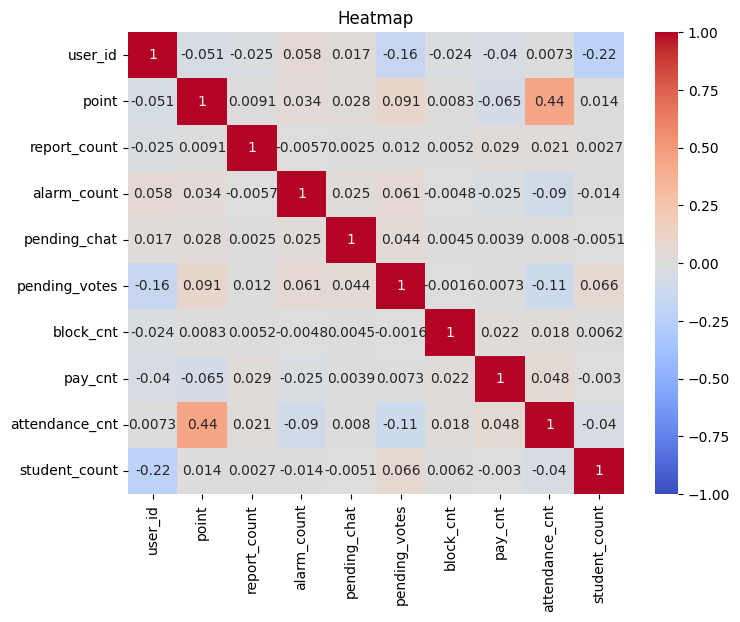

In [35]:
# 변수 간 상관계수 행렬 계산
corr_matrix = test.corr()

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Heatmap')
plt.show()

> 시각화를 통해 알 수 있는 부분
1. 출석 일수가 많을수록 포인트가 많을것임. (VIF에서도 두 변수가 상대적으로 높은 VIF 값을 가졌음)
2. 쌓인 투표수가 많을수록 보유 포인트가 많음. (두 변수는 연결지어 활발하게 이용하는 유저의 척도로서 볼 수 있을듯 함)

### 모델링 전 전처리
1. user_id 제거
2. 스케일링

In [37]:
# 라이브러리
from sklearn.cluster import (KMeans, DBSCAN)
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)

In [38]:
# master 원본 보존
cleaned = user.copy()

In [39]:
# user_id 제거
cleaned = cleaned.drop(columns=['user_id'])

# gender, ban_status 원핫 인코딩
cleaned = pd.get_dummies(cleaned, columns=['gender', 'ban_status', 'school_type', 'grade'])

# 정규화
ss = StandardScaler()
scaled_df = pd.DataFrame(
    ss.fit_transform(cleaned),
    columns=cleaned.columns
)

1. 차원축소 전

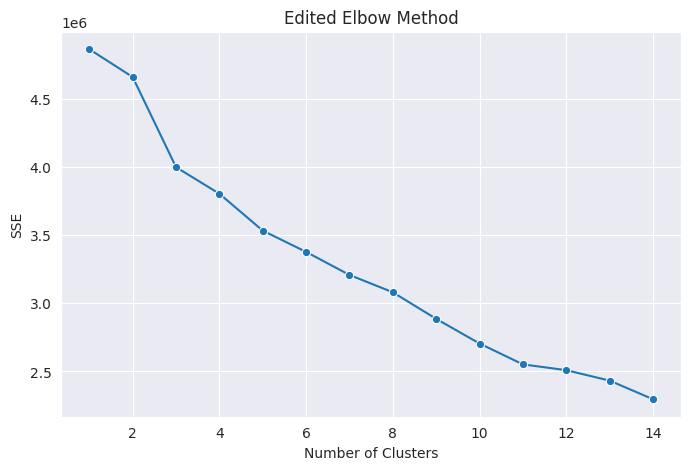

In [41]:
inertias = []

for k in range(1, 15):
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(scaled_df)
    inertias.append(model.inertia_)

# k값에 따른 inertia값 시각화
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 15), y=inertias, marker='o')
plt.title('Edited Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [42]:
kmeans_data = scaled_df.copy() # 라벨용 원본 복제

# 모델 생성 및 클러스터 수 설정
kmeans = KMeans(n_clusters=5, random_state=42) # 클러스터 개수 5개 설정
kmeans.fit(scaled_df) # 학습
labels = kmeans.predict(scaled_df)

# 시각화 대비
kmeans_data['labels'] = kmeans.predict(scaled_df)

# 클러스터별 개수 확인
pd.Series(labels).value_counts().sort_index()

0    18744
1    43578
2    56387
3    71467
4     4288
Name: count, dtype: int64

In [43]:
final_model = kmeans_data.copy()
final_model.groupby('labels').mean().T

labels,0,1,2,3,4
point,-0.011060,-0.004568,0.040063,-0.030457,0.075561
is_push_on,-2.502686,0.097943,0.250564,0.399571,-0.009913
report_count,-0.026160,0.003350,-0.017533,0.015559,0.051549
alarm_count,0.017779,-0.021519,0.076058,-0.049058,-0.041559
pending_chat,-0.024719,0.005309,0.014599,-0.011040,0.046107
pending_votes,-0.096527,0.013090,-0.009681,0.024791,0.003040
block_cnt,-0.102558,-0.102558,-0.102558,-0.102558,4.548513
block_any,-0.150158,-0.150158,-0.150158,-0.150158,6.659636
blocked_any,-0.030885,-0.013058,-0.006642,0.010539,0.179405
pay_cnt,-0.011296,0.007909,-0.103285,0.067863,0.196137


2. 차원 축소 후

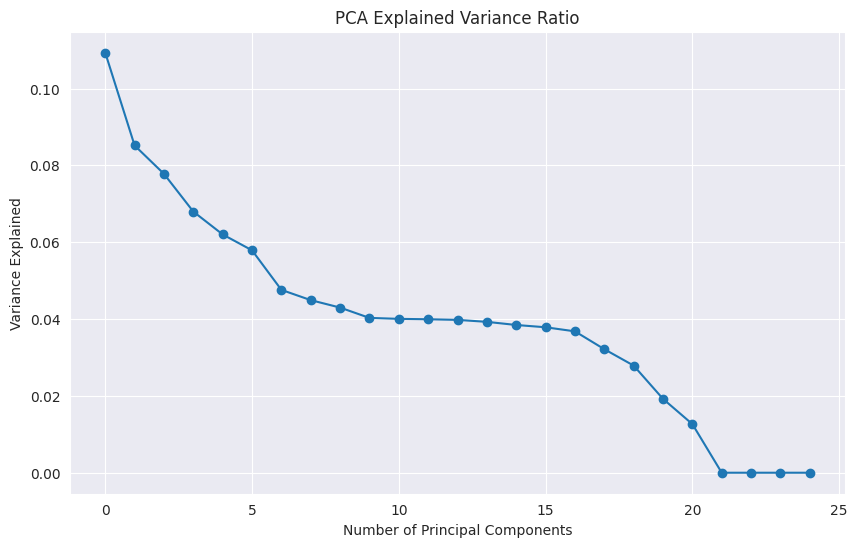

In [44]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
scaled_data_pca = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(scaled_data_pca)

# Scree Plot
num_components = len(pca.explained_variance_ratio_)

x = np.arange(num_components)
var = pca.explained_variance_ratio_

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(x, var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance Ratio')
plt.show()

In [45]:
X = scaled_df.copy()

pca = PCA(n_components=5)
x_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(x_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

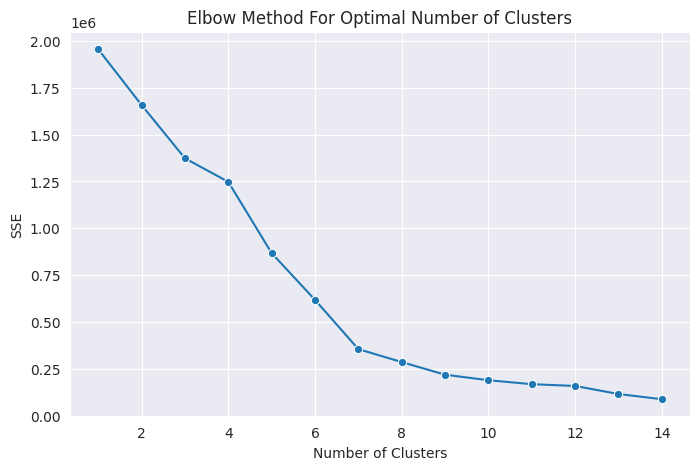

In [46]:
# 최적의 k 찾기 위한 elbow method 시각화
inertias = []

for k in range(1, 15):
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(pca_df)
    inertias.append(model.inertia_)

# k값에 따른 inertia값 시각화
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, 15), y=inertias, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [53]:
kmeans_data = scaled_df.copy() # 라벨용 원본 복제

# 모델 생성 및 클러스터 수 설정
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(pca_df) # 학습
labels = kmeans.predict(pca_df)

# 시각화 대비
kmeans_data['labels'] = kmeans.predict(pca_df)

# 클러스터별 개수 확인
pd.Series(labels).value_counts().sort_index()

0    60160
1    75204
2     2348
3     4232
4    52520
Name: count, dtype: int64

In [49]:
kmeans_data.columns

Index(['point', 'is_push_on', 'report_count', 'alarm_count', 'pending_chat',
       'pending_votes', 'block_cnt', 'block_any', 'blocked_any', 'pay_cnt',
       'question_rep_any', 'cand_any', 'attendance_cnt', 'student_count',
       'gender_F', 'gender_M', 'ban_status_N', 'ban_status_NB',
       'ban_status_RB', 'ban_status_W', 'school_type_H', 'school_type_M',
       'grade_1.0', 'grade_2.0', 'grade_3.0', 'labels'],
      dtype='object')

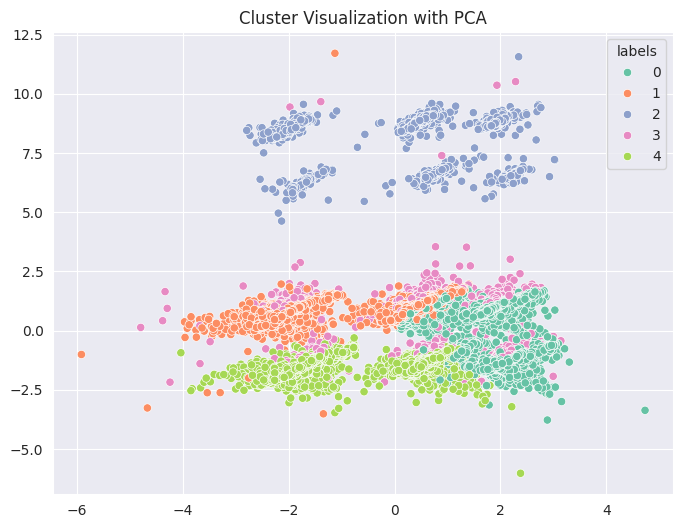

In [61]:
X_numeric = kmeans_data.drop(columns=['labels'])
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_numeric)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans_data['labels'], palette='Set2')
plt.title('Cluster Visualization with PCA')
plt.show()

In [55]:
final_model = kmeans_data.copy()
final_model.groupby('labels').mean().T

labels,0,1,2,3,4
point,-0.001671,0.064170,-0.114742,0.181048,-0.099430
is_push_on,-0.015410,0.032949,-0.191263,-0.005730,-0.020516
report_count,0.007999,-0.034144,-0.018954,0.050587,0.036500
alarm_count,-0.035483,0.053543,-0.496199,-0.034247,-0.011081
pending_chat,-0.009246,0.029526,0.063767,0.049056,-0.038492
pending_votes,0.036434,-0.020575,-0.282095,0.007158,-0.000238
block_cnt,-0.102558,-0.102558,0.032739,4.534992,-0.102558
block_any,-0.150158,-0.150158,0.055760,6.635499,-0.150158
blocked_any,0.006980,-0.014448,-0.008021,0.183902,-0.001766
pay_cnt,0.073632,-0.099675,-0.064487,0.193986,0.045634


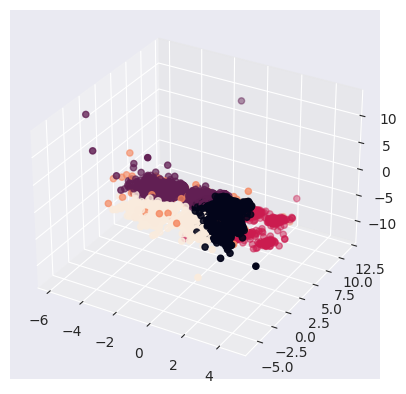

In [57]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=labels)

In [59]:
import pandas as pd

# df: feature dataframe, labels: 클러스터 라벨
cluster_means = kmeans_data.groupby(labels).mean()
cluster_diff = cluster_means.max() - cluster_means.min()
important_features = cluster_diff.sort_values(ascending=False)
print(important_features)

ban_status_N        9.146441
ban_status_W        9.092894
block_any           6.785657
block_cnt           4.637550
labels              4.000000
grade_1.0           2.070208
gender_F            2.026910
gender_M            2.026910
grade_2.0           1.260057
school_type_H       1.196486
school_type_M       1.196486
ban_status_RB       0.975963
grade_3.0           0.843627
alarm_count         0.549741
attendance_cnt      0.339699
pending_votes       0.318530
question_rep_any    0.308819
point               0.295791
pay_cnt             0.293662
student_count       0.284265
is_push_on          0.224212
cand_any            0.205369
blocked_any         0.198351
ban_status_NB       0.132803
pending_chat        0.102258
report_count        0.084731
dtype: float64


In [60]:
import pandas as pd

# 영향도 시리즈
importance = pd.Series({
    'ban_status_N': 9.146441,
    'ban_status_W': 9.092894,
    'block_any': 6.785657,
    'block_cnt': 4.637550,
    'labels': 4.000000,
    'grade_1.0': 2.070208,
    'gender_F': 2.026910,
    'gender_M': 2.026910,
    'grade_2.0': 1.260057,
    'school_type_H': 1.196486,
    'school_type_M': 1.196486,
    'ban_status_RB': 0.975963,
    'grade_3.0': 0.843627,
    'alarm_count': 0.549741,
    'attendance_cnt': 0.339699,
    'pending_votes': 0.318530,
    'question_rep_any': 0.308819,
    'point': 0.295791,
    'pay_cnt': 0.293662,
    'student_count': 0.284265,
    'is_push_on': 0.224212,
    'cand_any': 0.205369,
    'blocked_any': 0.198351,
    'ban_status_NB': 0.132803,
    'pending_chat': 0.102258,
    'report_count': 0.084731
})

# 변수 그룹핑
grouped = {
    'ban_status': ['ban_status_N','ban_status_W','ban_status_RB','ban_status_NB'],
    'grade': ['grade_1.0','grade_2.0','grade_3.0'],
    'gender': ['gender_F','gender_M'],
    'school_type': ['school_type_H','school_type_M']
}

# 합치기
grouped_importance = {}
for g, cols in grouped.items():
    grouped_importance[g] = importance[cols].sum()

# 나머지 개별 변수
others = [col for col in importance.index if not any(col in v for v in grouped.values())]
for col in others:
    grouped_importance[col] = importance[col]

# 정렬
grouped_importance = pd.Series(grouped_importance).sort_values(ascending=False)
print(grouped_importance)


ban_status          19.348101
block_any            6.785657
block_cnt            4.637550
grade                4.173892
gender               4.053820
labels               4.000000
school_type          2.392972
alarm_count          0.549741
attendance_cnt       0.339699
pending_votes        0.318530
question_rep_any     0.308819
point                0.295791
pay_cnt              0.293662
student_count        0.284265
is_push_on           0.224212
cand_any             0.205369
blocked_any          0.198351
pending_chat         0.102258
report_count         0.084731
dtype: float64
